In [77]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, \
                            roc_auc_score, roc_curve
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.spatial.distance import cosine as cos_dist

plt.rcParams['figure.figsize'] = [10, 10]

In [78]:
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

# Backtest results
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
def backtest(X_validation, Y_validation, predictions):
    backtestdata = pd.DataFrame(index=X_validation.index)
    backtestdata['signal_pred'] = predictions
    backtestdata['signal_actual'] = Y_validation
    backtestdata['Market Returns'] = X_validation['Close'].pct_change()
    backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
    backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
    backtestdata=backtestdata.reset_index()
    backtestdata.head()
    backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
    backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
    
    return backtestdata

# Hackathon #2 - Data Wrangling (Instructor solution)

Table of Contents
- [Load Wrangled Train Dataframe](#Load-Wrangled-Train-Dataframe)
- [EDA](#EDA)
- [Feature Selection](#Feature-Selection)
- [Random Forest Classifier](#Random-Forest-Classifier)
- [Classify Test Data](#Classify-Test-Data)

## Load Wrangled Train Dataframe

In [79]:
df = pd.read_csv("merge_data.csv").set_index('timestamp')
#display(df)
df

,rsi10,%k200,%k30,ema10,open,high,low,close,volume_(btc),volume_(currency),weighted_price,volumn_square,ma10,rsi30,%k10,ema200,ma200,rsi200,Unnamed: 0,signal
timestamp,,,,,,,,,,,,,,,,,,,,
1325317920,NaN,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325317980,NaN,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318040,NaN,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318100,NaN,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318160,NaN,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355317380,NaN,NaN,NaN,NaN,13.34,13.34,13.34,13.34,3.900000,52.026,13.34,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1355317440,NaN,NaN,NaN,NaN,13.34,13.34,13.34,13.34,3.900000,52.026,13.34,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1355317500,NaN,NaN,NaN,NaN,13.34,13.34,13.34,13.34,3.900000,52.026,13.34,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [80]:
#df.describe()

In [81]:
#df.dtypes

In [82]:
#df[df.columns.difference(['timestamp'])].plot.box(vert = False, grid = True)

In [83]:
#colours = ['#808080','#FFFFFF'] # specify the colours - gray is missing. white is not missing.
#sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

In [84]:
#df['signal'].value_counts().plot(kind='bar')

In [85]:

df_new = df.drop(['Unnamed: 0','%k200'], axis=1).copy()

y = df_new['signal']
y = y.dropna()

In [86]:
''' Index(['timestamp', 'close', 'ema10', 'ema30', 'ema200', 'roc10', 'roc30',
       'mom10', 'mom30', 'rsi10', 'rsi30', 'rsi200', '%k10', '%d10', '%k30',
       '%d30', '%k200', '%d200', 'ma10', 'ma30', 'ma200']
'''

" Index(['timestamp', 'close', 'ema10', 'ema30', 'ema200', 'roc10', 'roc30',\n       'mom10', 'mom30', 'rsi10', 'rsi30', 'rsi200', '%k10', '%d10', '%k30',\n       '%d30', '%k200', '%d200', 'ma10', 'ma30', 'ma200']\n"

In [87]:
df_new

,rsi10,%k30,ema10,open,high,low,close,volume_(btc),volume_(currency),weighted_price,volumn_square,ma10,rsi30,%k10,ema200,ma200,rsi200,signal
timestamp,,,,,,,,,,,,,,,,,,
1325317920,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325317980,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318040,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318100,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325318160,NaN,NaN,NaN,4.39,4.39,4.39,4.39,0.455581,2.000,4.39,4.079757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355317380,NaN,NaN,NaN,13.34,13.34,13.34,13.34,3.900000,52.026,13.34,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1355317440,NaN,NaN,NaN,13.34,13.34,13.34,13.34,3.900000,52.026,13.34,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1355317500,NaN,NaN,NaN,13.34,13.34,13.34,13.34,3.900000,52.026,13.34,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Selection

In [88]:
def clean (df):
    #df1=df1.fillna(method='ffill').fillna(method='bfill')
    
    df["close"] = df["close"].fillna(method="ffill")
    df["open"] = df["open"].fillna(method="ffill")
    df["low"] = df["low"].fillna(method="ffill")
    df["high"] = df["high"].fillna(method="ffill")
    
    df["ema10"] = df.ema10.fillna(EMA(df, 10))

    df["ema30"] = EMA(df, 30)
    df["ema200"] = df.ema200.fillna(EMA(df, 200))
    
    df["ma10"] = df.ma10.fillna(MA(df, 10))
    df["ma30"] = MA(df, 30)
    df["ma200"] = df.ma200.fillna(MA(df, 200))
    
    df["roc10"] = ROC(df["close"], 10)
    df["roc30"] = ROC(df["close"], 30)
     
    df["mom10"] = MOM(df["close"], 10) 
    df["mom30"] = MOM(df["close"], 30) 
    
    df["rsi10"] = df.rsi10.fillna( RSI(df["close"], 10) )
    df["rsi30"] = df.rsi30.fillna( RSI(df["close"], 30) )
   
    df["rsi200"] = df.rsi30.fillna( RSI(df["close"], 200))
    
     
    df["%k10"] = STOK(df["close"], df["low"], df["high"], 10)
    df["%k30"] = STOK(df["close"], df["low"], df["high"], 30)
    df["%k200"] = STOK(df["close"], df["low"], df["high"], 200)
    df["%d10"] = STOD(df["close"], df["low"], df["high"], 10)
    df["%d30"] = STOD(df["close"], df["low"], df["high"], 30)
    df["%d200"] = STOD(df["close"], df["low"], df["high"], 200)
    df_filtered = df[['close', 'ema10', 'ema30', 'ema200','ma10', 'ma30', 'ma200', 'roc10', 'roc30', 'mom10', 'mom30', 'rsi10', 'rsi30', 'rsi200','%k10', '%k30', '%k200', '%d10', '%d30', '%d200']].copy()

    ''''''
    df_filtered = df.dropna(subset = 'signal')
    
    df_filtered = df_filtered[[ 'ema10', 'ema30', 'ema200','ma10', 'ma30', 'ma200', 'roc10', 'roc30', 'mom10', 'mom30', 'rsi10', 'rsi30', 'rsi200']].copy()

    #df_filtered = df_filtered.dropna(subset = 'signal')
    
    #df_filtered=df_filtered.fillna(method='ffill').fillna(method='bfill')
    
    return df_filtered
    
  



In [89]:
X = clean(df_new)
X.corr()

/tmp/ipykernel_6561/1261789262.py:24: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
/tmp/ipykernel_6561/1261789262.py:26: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
/tmp/ipykernel_6561/1261789262.py:24: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be

,ema10,ema30,ema200,ma10,ma30,ma200,roc10,roc30,mom10,mom30,rsi10,rsi30,rsi200
ema10,1.000000,0.999518,0.993761,0.999959,0.999407,0.991388,-0.005129,0.009209,-0.000271,0.017866,-0.041204,-0.035086,-0.035086
ema30,0.999518,1.000000,0.993606,0.999440,0.999971,0.991285,-0.017238,0.000379,-0.012497,0.010252,-0.039445,-0.034920,-0.034920
ema200,0.993761,0.993606,1.000000,0.993665,0.993558,0.999558,-0.014028,-0.011019,-0.013071,-0.007588,-0.073204,-0.091823,-0.091823
ma10,0.999959,0.999440,0.993665,1.000000,0.999342,0.991282,-0.007853,0.006420,-0.003044,0.015137,-0.043856,-0.036664,-0.036664
ma30,0.999407,0.999971,0.993558,0.999342,1.000000,0.991235,-0.020383,-0.004179,-0.016263,0.005843,-0.040750,-0.036088,-0.036088
ma200,0.991388,0.991285,0.999558,0.991282,0.991235,1.000000,-0.014667,-0.012808,-0.014073,-0.010158,-0.075631,-0.098998,-0.098998
roc10,-0.005129,-0.017238,-0.014028,-0.007853,-0.020383,-0.014667,1.000000,0.709287,0.913530,0.623439,0.278992,0.240885,0.240885
roc30,0.009209,0.000379,-0.011019,0.006420,-0.004179,-0.012808,0.709287,1.000000,0.687068,0.929212,0.322667,0.295878,0.295878
mom10,-0.000271,-0.012497,-0.013071,-0.003044,-0.016263,-0.014073,0.913530,0.687068,1.000000,0.671649,0.299257,0.261235,0.261235
mom30,0.017866,0.010252,-0.007588,0.015137,0.005843,-0.010158,0.623439,0.929212,0.671649,1.000000,0.319786,0.300660,0.300660


## Get train & Test Data

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Random Forest Classifier

In [91]:
clf = RandomForestClassifier(n_estimators=400, 
            max_depth=32, 
            max_features=1.0,
            random_state=0,
            n_jobs=-1)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [92]:

predicted_proba= clf.predict_proba(X_test)

roc_auc = roc_auc_score(y_score=predicted_proba[:,1], y_true= y_test)
   
#confmat = confusion_matrix(y_true=y_test, y_pred=x1)
print('The AUROC of our classifier is = %.3f' % roc_auc)

feature_importances = pd.Series(data=clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False)

The AUROC of our classifier is = 0.980


ema200    0.220531
ma200     0.207510
ema10     0.085820
rsi10     0.077781
ma10      0.073817
ema30     0.067985
ma30      0.060243
rsi200    0.047661
rsi30     0.047255
roc30     0.040212
mom30     0.028700
roc10     0.025033
mom10     0.017452
dtype: float64

## HyperParameter Tunning

## Feature importance

<AxesSubplot:>

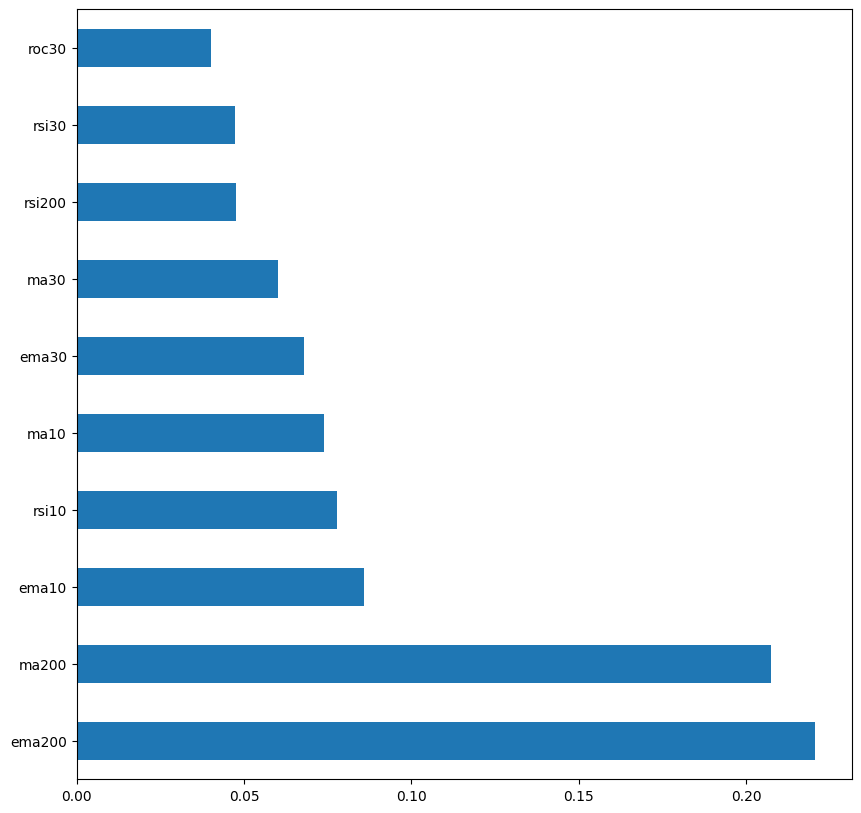

In [93]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [94]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predicted_proba= clf.predict_proba(X_test)

roc_auc = roc_auc_score(y_score=predicted_proba[:,1], y_true= y_test)
   
#confmat = confusion_matrix(y_true=y_test, y_pred=x1)
print('The AUROC of our classifier is = %.3f' % roc_auc)


The AUROC of our classifier is = 0.792


/home/francisco/.virtualenvs/slu01/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## Classify Test Data

In [103]:
df_test = pd.read_csv("data/test.csv")

#lowercase column names to match wrangled dataframe
df_test =df_test.set_index('Timestamp')
df_test.columns = df_test.columns.str.lower()
df_test


,close,ema10,ema30,ema200,roc10,roc30,mom10,mom30,rsi10,rsi30,rsi200,%k10,%d10,%k30,%d30,%k200,%d200,ma10,ma30,ma200
Timestamp,,,,,,,,,,,,,,,,,,,,
1351998180,10.68,10.639059,10.636231,10.625343,0.093721,0.093721,0.02,0.01,54.947707,52.577501,50.058105,100.000000,89.855072,100.000000,89.855072,93.103448,81.572117,10.641,10.646667,10.59470
1351999140,10.68,10.646502,10.639055,10.625887,0.093721,0.000000,0.01,0.01,54.947707,52.577501,50.058105,100.000000,97.101449,100.000000,97.101449,93.103448,88.950686,10.642,10.647000,10.59585
1352000460,10.64,10.645320,10.639116,10.626027,-0.187617,-0.374532,-0.03,-0.04,49.730027,50.688799,49.791450,82.608696,94.202899,82.608696,94.202899,79.310345,88.505747,10.639,10.645667,10.59650
1352000520,10.60,10.637080,10.636592,10.625768,-0.656045,-0.749064,-0.06,-0.08,44.983869,48.872645,49.526302,65.217391,82.608696,65.217391,82.608696,65.517241,79.310345,10.633,10.643000,10.59705
1352000640,10.50,10.612157,10.627780,10.624517,-1.685393,-1.593252,-0.17,-0.18,35.557367,44.728033,48.872398,21.739130,56.521739,21.739130,56.521739,31.034483,58.620690,10.616,10.637000,10.59710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355314260,13.34,13.381654,13.397634,13.370544,-0.670141,-0.373413,-0.09,-0.05,17.747752,37.647693,49.995688,0.000000,0.000000,0.000000,0.000000,70.000000,74.444444,13.394,13.406000,13.37065
1355314320,13.33,13.372263,13.393270,13.370141,-0.744602,-0.448096,-0.10,-0.06,15.850286,36.089430,49.868857,0.000000,0.000000,0.000000,0.000000,66.666667,70.000000,13.384,13.404000,13.37030
1355315400,13.42,13.380942,13.394995,13.370637,-0.074460,0.224048,-0.01,0.03,59.330877,53.867217,50.993373,90.000000,30.000000,90.000000,30.000000,96.666667,77.777778,13.383,13.405000,13.37040


In [104]:
def cleanTEST (df):
    
    #df1=df1.fillna(method='ffill').fillna(method='bfill')
    
    
    df_filtered = df[[ 'ema10', 'ema30', 'ema200','ma10', 'ma30', 'ma200', 'roc10', 'roc30', 'mom10', 'mom30', 'rsi10', 'rsi30', 'rsi200']].copy()


    #df1 = df.dropna(subset = 'signal')
    
    df_filtered=df_filtered.fillna(method='ffill').fillna(method='bfill')
    
    #df1 = df_filtered[[ 'ema10', 'ema30', 'ema200','rsi10', 'rsi30', 'rsi200', '%k10', '%k30',  'ma200','mom10','mom30','ma30']]
    
    return df_filtered

   

In [105]:
clean_maybe = cleanTEST(df_test)
clean_maybe

,ema10,ema30,ema200,ma10,ma30,ma200,roc10,roc30,mom10,mom30,rsi10,rsi30,rsi200
Timestamp,,,,,,,,,,,,,
1351998180,10.639059,10.636231,10.625343,10.641,10.646667,10.59470,0.093721,0.093721,0.02,0.01,54.947707,52.577501,50.058105
1351999140,10.646502,10.639055,10.625887,10.642,10.647000,10.59585,0.093721,0.000000,0.01,0.01,54.947707,52.577501,50.058105
1352000460,10.645320,10.639116,10.626027,10.639,10.645667,10.59650,-0.187617,-0.374532,-0.03,-0.04,49.730027,50.688799,49.791450
1352000520,10.637080,10.636592,10.625768,10.633,10.643000,10.59705,-0.656045,-0.749064,-0.06,-0.08,44.983869,48.872645,49.526302
1352000640,10.612157,10.627780,10.624517,10.616,10.637000,10.59710,-1.685393,-1.593252,-0.17,-0.18,35.557367,44.728033,48.872398
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355314260,13.381654,13.397634,13.370544,13.394,13.406000,13.37065,-0.670141,-0.373413,-0.09,-0.05,17.747752,37.647693,49.995688
1355314320,13.372263,13.393270,13.370141,13.384,13.404000,13.37030,-0.744602,-0.448096,-0.10,-0.06,15.850286,36.089430,49.868857
1355315400,13.380942,13.394995,13.370637,13.383,13.405000,13.37040,-0.074460,0.224048,-0.01,0.03,59.330877,53.867217,50.993373


In [106]:
predicted_proba = clf.predict_proba(clean_maybe)
res = pd.DataFrame(index=clean_maybe.index, data=predicted_proba[:,1])
res['signal'] = res[0]
res = res.drop(0, axis=1)

res.to_csv(r'PleaseBeGood5.csv', index = True)